In [1]:
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("100")') # limits the height of output so it doesn't take up the whole notebook screen

!pip install pygeos census geopandas mapclassify contextily adjustText # Install geopandas and mapclassify (used for interactive mapping)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 28.7 MB/s 
     |████████████████████████████████| 1.0 MB 13.4 MB/s 
     |████████████████████████████████| 16.7 MB 764 kB/s 
     |████████████████████████████████| 6.3 MB 43.9 MB/s 
     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 19.3 MB 2.6 MB/s 
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7096 sha256=22ded24342bac4f5bb5cb08212675f69d2de7739576a0e1978ab2684c7974945
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [2]:
import pygeos
import os
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import folium
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import mapclassify
from census import Census
import contextily as ctx 
from adjustText import adjust_text

plt.rcParams["figure.figsize"] = (10,10) # set this once for a default plot size

In [3]:
from google.colab import drive # this mounts your Google Drive; you have to authenticate it each time I think unfortunately
drive.mount('/drive')
# executes in 15 seconds for me

Mounted at /drive


In [4]:
#loading in TIGER shapefiles
url_us_county = r'https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip' #loading us counties , for some reason it generated a '404 Not found' error when I directly tried loading New York state's counties
us_county = gpd.read_file(url_us_county)
ny_county = us_county[us_county["STATEFP"] == '36'] #filtering to include only new york state
url_ny_tracts = r'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_36_tract.zip'
ny_tracts = gpd.read_file(url_ny_tracts)

In [5]:
#loading dataset
ny_arrest = gpd.read_file('/drive/MyDrive/Github/Data/Brooklyn_Arrest_2019/nyc_arrest_cov.csv') #loading NY Arrest data
sub_station = gpd.read_file('/drive/MyDrive/Github/Data/Brooklyn_Arrest_2019/Subway Stations.geojson') #loading Subway Station data
sub_line = gpd.read_file('/drive/MyDrive/Github/Data/Brooklyn_Arrest_2019/Subway Lines.geojson') #loading subway lines data

In [6]:
#assigning geometries from lat long
ny_arrest = gpd.GeoDataFrame(ny_arrest, crs='epsg:2263', geometry=gpd.points_from_xy(ny_arrest['X_COORD_CD'], ny_arrest['Y_COORD_CD'])) #setting geometry and coordinate system to arrest data
ny_arrest.head()

field_1 ARREST_KEY ARREST_DATE  PD_CD           PD_DESC  KY_CD   OFNS_DESC  \
0       4  192799737  01/26/2019  177.0      SEXUAL ABUSE  116.0  SEX CRIMES   
1       5  193260691  02/06/2019                                               
2      22  196324211  04/23/2019  157.0            RAPE 1  104.0        RAPE   
3      23  196785901  05/04/2019  175.0  SEXUAL ABUSE 3,2  233.0  SEX CRIMES   
4      25  197554056  05/23/2019  175.0  SEXUAL ABUSE 3,2  233.0  SEX CRIMES   

     LAW_CODE LAW_CAT_CD ARREST_BORO  ... AGE_GROUP PERP_SEX       PERP_RACE  \
0  PL 1306503          F           M  ...     45-64        M           BLACK   
1  PL 2203400          F           M  ...     25-44        M         UNKNOWN   
2  PL 1303501          F           K  ...     45-64        M  BLACK HISPANIC   
3  PL 13052A1          M           B  ...     25-44        M           BLACK   
4  PL 13052A1          M           M  ...     45-64        F           BLACK   

  X_COORD_CD Y_COORD_CD            Latitude           Longitude  \
0  1000555.0   230994.0  40.800694331000045  -73.94110928599997   
1   986685.0   215375.0   40.75783900300007  -73.99121211099998   
2  1003606.0   185050.0   40.67458330800008  -73.93022154099998   
3  1011257.0   261130.0  40.883382579000056  -73.90233330899997   
4   996241.0   236149.0   40.81485028900005  -73.95668184799996   

                                         Lon_Lat  YEAR  \
0  POINT (-73.94110928599997 40.800694331000045)  2019   
1   POINT (-73.99121211099998 40.75783900300007)  2019   
2   POINT (-73.93022154099998 40.67458330800008)  2019   
3   POINT (-73.90233330899997 40.88338257900006)  2019   
4   POINT (-73.95668184799996 40.81485028900005)  2019   

                         geometry  
0  POINT (1000555.000 230994.000)  
1   POINT (986685.000 215375.000)  
2  POINT (1003606.000 185050.000)  
3  POINT (1011257.000 261130.000)  
4   POINT (996241.000 236149.000)  

[5 rows x 22 columns]

In [7]:
#filtering arrests to brooklyn
brooklyn_arrest = ny_arrest[ny_arrest["ARREST_BORO"] == "K"]
brooklyn_arrest.head()

field_1 ARREST_KEY ARREST_DATE  PD_CD               PD_DESC  KY_CD  \
2       22  196324211  04/23/2019  157.0                RAPE 1  104.0   
6       42  192148546  01/10/2019  168.0              SODOMY 1  116.0   
12      66  191717184  01/01/2019  105.0     STRANGULATION 1ST  106.0   
14      76  192068590  01/09/2019  793.0  WEAPONS POSSESSION 3  118.0   
17      91  205007433  11/11/2019  105.0     STRANGULATION 1ST  106.0   

            OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  ... AGE_GROUP  \
2                RAPE  PL 1303501          F           K  ...     45-64   
6          SEX CRIMES  PL 1305003          F           K  ...     25-44   
12     FELONY ASSAULT  PL 1211200          F           K  ...     45-64   
14  DANGEROUS WEAPONS  PL 2650201          F           K  ...     25-44   
17     FELONY ASSAULT  PL 1211200          F           K  ...     25-44   

   PERP_SEX       PERP_RACE X_COORD_CD Y_COORD_CD           Latitude  \
2         M  BLACK HISPANIC  1003606.0   185050.0  40.67458330800008   
6         M           BLACK  1017141.0   183798.0  40.67110691100004   
12        F           WHITE   982473.0   168770.0  40.62991922600003   
14        F           BLACK   976209.0   165633.0  40.62130534600004   
17        M           BLACK   995254.0   181232.0  40.66411807000002   

             Longitude                                       Lon_Lat  YEAR  \
2   -73.93022154099998  POINT (-73.93022154099998 40.67458330800008)  2019   
6   -73.88143295699997  POINT (-73.88143295699996 40.67110691100004)  2019   
12  -74.00640337899993  POINT (-74.00640337899995 40.62991922600003)  2019   
14  -74.02896673699996  POINT (-74.02896673699996 40.62130534600004)  2019   
17  -73.96033738499993  POINT (-73.96033738499995 40.66411807000003)  2019   

                          geometry  
2   POINT (1003606.000 185050.000)  
6   POINT (1017141.000 183798.000)  
12   POINT (982473.000 168770.000)  
14   POINT (976209.000 165633.000)  
17   POINT (995254.000 181232.000)  

[5 rows x 22 columns]

In [8]:
#filtering county data to include only brooklyn
brooklyn = ny_county[ny_county['NAME']=='Kings'] 
brooklyn.to_crs('epsg:2263', inplace=True)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
#clipping tracts to brooklyn
ny_tracts.to_crs('epsg:2263', inplace=True)
brooklyn_tracts = ny_tracts.clip(brooklyn)
brooklyn_tracts.to_crs(epsg=2263, inplace=True) #projecting to long island state plane
brooklyn_tracts.explore(height=450)

In [10]:
#clipping subway lines to brooklyn
sub_line.to_crs('epsg:2263', inplace=True)
brooklyn_lines = sub_line.clip(brooklyn)
brooklyn_lines.to_crs(epsg=2263, inplace=True) #projecting to long island state plane
brooklyn_lines.explore(height=450)

In [11]:
#creating quarter mile buffers along all subway stations in brooklyn
sub_station.to_crs('epsg:2263', inplace=True)
brooklyn_sub_stn = sub_station.clip(brooklyn) #clipping to only subway stations in brooklyn
brooklyn_sub_stn = brooklyn_sub_stn.to_crs(epsg=2263) #projecting to the long island state plane
sub_stn_buf = brooklyn_sub_stn.buffer(1320) #creating quater mile buffers around the stations
eval_js('google.colab.output.setIframeHeight("500")')
sub_stn_buf.explore(height = 450)

In [12]:
#making all the buffer polygons into one single multipolygon with Unary Union
eval_js('google.colab.output.setIframeHeight("500")') 
near_sub_stn = gpd.GeoDataFrame(index=[0], crs='epsg:2263', geometry=[sub_stn_buf.unary_union])
near_sub_stn.explore(height = 450)

**Overlay Operation- Difference**

In [13]:
#creating overlay by employing the Difference method to generate polygon inside Brooklyn with areas other than those within a quater mile of a subway station
far_sub_stn = brooklyn.overlay(near_sub_stn, how='difference')
far_sub_stn.explore(height = 450)

In [14]:
#appending the polygons- near subway and farther away from subway stations with indentifier keys
brook_sub_near_far = near_sub_stn.append(far_sub_stn, ignore_index=True)
brook_sub_near_far['key'] = ""
brook_sub_near_far.loc[0,'key'] = 'Near Subway Stations'
brook_sub_near_far.loc[1,'key'] = 'Away from Subway Stations'
brook_sub_near_far


geometry STATEFP COUNTYFP  \
0  MULTIPOLYGON (((986389.223 157320.086, 986263....     NaN      NaN   
1  MULTIPOLYGON (((968635.258 171505.949, 968643....      36      047   

   COUNTYNS  GEOID   NAME      NAMELSAD LSAD CLASSFP  MTFCC CSAFP CBSAFP  \
0       NaN    NaN    NaN           NaN  NaN     NaN    NaN   NaN    NaN   
1  00974122  36047  Kings  Kings County   06      H6  G4020   408  35620   

  METDIVFP FUNCSTAT        ALAND      AWATER     INTPTLAT      INTPTLON  \
0      NaN      NaN          NaN         NaN          NaN           NaN   
1    35614        C  179671310.0  71098973.0  +40.6350451  -073.9506398   

                         key  
0       Near Subway Stations  
1  Away from Subway Stations

In [15]:
#spatially joining the appended polygon to the arrest gdf
brooklyn_arrest_sub = brooklyn_arrest.sjoin(brook_sub_near_far, how="left")
brooklyn_arrest_sub

field_1 ARREST_KEY ARREST_DATE  PD_CD  \
2           22  196324211  04/23/2019  157.0   
6           42  192148546  01/10/2019  168.0   
12          66  191717184  01/01/2019  105.0   
14          76  192068590  01/09/2019  793.0   
17          91  205007433  11/11/2019  105.0   
...        ...        ...         ...    ...   
354996  355956  206916517  01/03/2020  569.0   
354999  355959  206920533  01/04/2020  779.0   
355007  355967  207868603  01/13/2020  203.0   
355024  355984  207645841  01/09/2020  439.0   
355026  355986  206891807  01/01/2020  113.0   

                                          PD_DESC  KY_CD  \
2                                          RAPE 1  104.0   
6                                        SODOMY 1  116.0   
12                              STRANGULATION 1ST  106.0   
14                           WEAPONS POSSESSION 3  118.0   
17                              STRANGULATION 1ST  106.0   
...                                           ...    ...   
354996                      MARIJUANA, SALE 4 & 5  235.0   
354999             PUBLIC ADMINISTRATION,UNCLASSI  126.0   
355007                       TRESPASS 3, CRIMINAL  352.0   
355024  LARCENY,GRAND FROM OPEN AREAS, UNATTENDED  109.0   
355026                      MENACING,UNCLASSIFIED  344.0   

                           OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  ...  \
2                               RAPE  PL 1303501          F           K  ...   
6                         SEX CRIMES  PL 1305003          F           K  ...   
12                    FELONY ASSAULT  PL 1211200          F           K  ...   
14                 DANGEROUS WEAPONS  PL 2650201          F           K  ...   
17                    FELONY ASSAULT  PL 1211200          F           K  ...   
...                              ...         ...        ...         ...  ...   
354996               DANGEROUS DRUGS  PL 2214000          M           K  ...   
354999       MISCELLANEOUS PENAL LAW  PL 215510B          F           K  ...   
355007             CRIMINAL TRESPASS  PL 140100A          M           K  ...   
355024                 GRAND LARCENY  PL 1553001          F           K  ...   
355026  ASSAULT 3 & RELATED OFFENSES  PL 1201401          M           K  ...   

        MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT        ALAND      AWATER  \
2       G4020   408  35620    35614        C  179671310.0  71098973.0   
6         NaN   NaN    NaN      NaN      NaN          NaN         NaN   
12        NaN   NaN    NaN      NaN      NaN          NaN         NaN   
14        NaN   NaN    NaN      NaN      NaN          NaN         NaN   
17        NaN   NaN    NaN      NaN      NaN          NaN         NaN   
...       ...   ...    ...      ...      ...          ...         ...   
354996    NaN   NaN    NaN      NaN      NaN          NaN         NaN   
354999  G4020   408  35620    35614        C  179671310.0  71098973.0   
355007    NaN   NaN    NaN      NaN      NaN          NaN         NaN   
355024  G4020   408  35620    35614        C  179671310.0  71098973.0   
355026  G4020   408  35620    35614        C  179671310.0  71098973.0   

           INTPTLAT      INTPTLON                        key  
2       +40.6350451  -073.9506398  Away from Subway Stations  
6               NaN           NaN       Near Subway Stations  
12              NaN           NaN       Near Subway Stations  
14              NaN           NaN       Near Subway Stations  
17              NaN           NaN       Near Subway Stations  
...             ...           ...                        ...  
354996          NaN           NaN       Near Subway Stations  
354999  +40.6350451  -073.9506398  Away from Subway Stations  
355007          NaN           NaN       Near Subway Stations  
355024  +40.6350451  -073.9506398  Away from Subway Stations  
355026  +40.6350451  -073.9506398  Away from Subway Stations  

[96546 rows x 41 columns]

In [16]:
#inspecting the number of arrests that took place in the two regions
brooklyn_arrest_sub['key'].value_counts()

Near Subway Stations         55195
Away from Subway Stations    41321
Name: key, dtype: int64

(965427.2688189194, 1033697.5103229588, 136606.41049684992, 212102.62575293807)

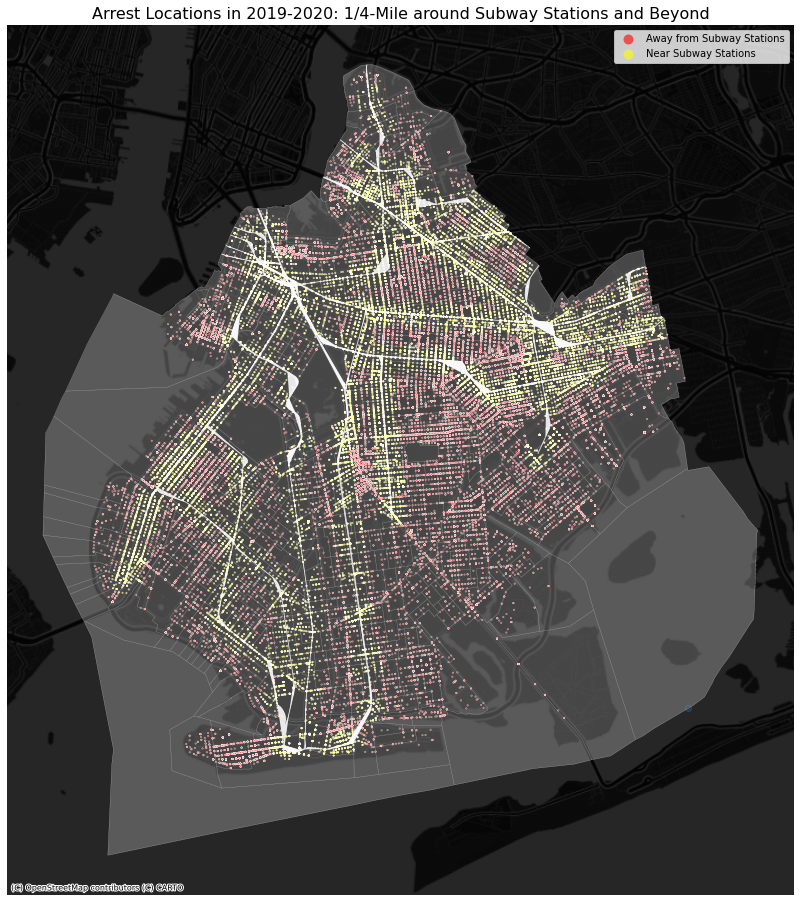

In [17]:
#plotting the arrests by their location- within or outside a quater mile radius around subway stations
plt.figure(figsize = (20,16))

ax1 = plt.subplot(111)

brooklyn_tracts.plot(alpha = 0.3, legend = True, ax=ax1, edgecolor = 'white', linewidth = .3, facecolor = '#D3D3D3')

brooklyn_lines.plot(alpha = 0.9, legend = True, ax=ax1, edgecolor = 'white', linewidth = .8, facecolor = '#fafafc')

brooklyn_arrest_sub.plot('key', alpha = 0.6, ax=ax1, legend=True, cmap = 'autumn', edgecolor = 'white', linewidth = .6, markersize = 2)

plt.title("Arrest Locations in 2019-2020: 1/4-Mile around Subway Stations and Beyond", size = 16);
ctx.add_basemap(ax1,source=ctx.providers.CartoDB.DarkMatterNoLabels, crs = brooklyn_tracts.crs);
ax1.axis('off')

So, which subway stations contributed to how many arrests?

In [18]:
#adding the buffer geoseries to the subway stations gdf and reassigning its geometry to the buffer (polygon) geometry
brooklyn_sub_stn["Stn_Buf_0.25"] = sub_stn_buf #adding buffer Geoseries to Geodataframe to be able to do spatial join
brooklyn_stn_buf = brooklyn_sub_stn.set_geometry("Stn_Buf_0.25", drop=True, inplace=False, crs="epsg:2263") #reassigning geometry and dropping previous geometry
brooklyn_stn_buf.rename(columns={"Stn_Buf_0.25": "geomtery"}) #renaming to geomtery

name                                url line objectid  \
197  W 8th St - NY Aquarium  http://web.mta.info/nyct/service/  F-Q      198   
99               Ocean Pkwy  http://web.mta.info/nyct/service/    Q      100   
326          Brighton Beach  http://web.mta.info/nyct/service/  B-Q      327   
332             Neptune Ave  http://web.mta.info/nyct/service/    F      333   
333                   Ave X  http://web.mta.info/nyct/service/    F      334   
..                      ...                                ...  ...      ...   
281     Bushwick - Aberdeen  http://web.mta.info/nyct/service/    L      282   
226             Crescent St  http://web.mta.info/nyct/service/  J-Z      227   
73               Wilson Ave  http://web.mta.info/nyct/service/    L       74   
227           Cypress Hills  http://web.mta.info/nyct/service/    J      228   
69              Classon Ave  http://web.mta.info/nyct/service/    G       70   

                                                 notes  \
197                                      F,Q-all times   
99                                         Q-all times   
326               B-weekdays and evenings, Q-all times   
332                                        F-all times   
333                                        F-all times   
..                                                 ...   
281                                        L-all times   
226  J-all times, Z-rush hours AM westbound, PM eas...   
73                                         L-all times   
227                                        J-all times   
69                                         G-all times   

                                              geometry  
197  POLYGON ((992248.816 149142.013, 992242.460 14...  
99   POLYGON ((994320.273 149243.897, 994313.917 14...  
326  POLYGON ((996305.510 149754.211, 996299.154 14...  
332  POLYGON ((992627.552 150856.247, 992621.196 15...  
333  POLYGON ((992717.377 154029.875, 992711.021 15...  
..                                                 ...  
281  POLYGON ((1011845.845 188075.171, 1011839.489 ...  
226  POLYGON ((1020535.823 188192.519, 1020529.467 ...  
73   POLYGON ((1012204.879 190263.693, 1012198.523 ...  
227  POLYGON ((1020700.840 190547.544, 1020694.484 ...  
69   POLYGON ((996665.854 190259.808, 996659.498 19...  

[169 rows x 6 columns]

In [19]:
# using the pivot table approach to join the points(arrests) to the polygons (buffers) aggregating on the total counts for years 2019 and 2020
brook_sub_arrest = ny_arrest.sjoin(brooklyn_stn_buf, how="left") 
dfpivot = pd.pivot_table(brook_sub_arrest,index='objectid',columns='YEAR',aggfunc={"YEAR": "count"}) #aggregating on yearly arrest counts
dfpivot.columns = dfpivot.columns.droplevel() # drops the header row with "YEAR" and makes each column name one of the types
brook_sub_arrest_counts = brooklyn_stn_buf.merge(dfpivot, how='left', on = 'objectid')
brook_sub_arrest_counts.head()

name                                url line objectid  \
0  W 8th St - NY Aquarium  http://web.mta.info/nyct/service/  F-Q      198   
1              Ocean Pkwy  http://web.mta.info/nyct/service/    Q      100   
2          Brighton Beach  http://web.mta.info/nyct/service/  B-Q      327   
3             Neptune Ave  http://web.mta.info/nyct/service/    F      333   
4                   Ave X  http://web.mta.info/nyct/service/    F      334   

                                  notes  \
0                         F,Q-all times   
1                           Q-all times   
2  B-weekdays and evenings, Q-all times   
3                           F-all times   
4                           F-all times   

                                            geometry  2019  2020  
0  POLYGON ((992248.816 149142.013, 992242.460 14...   985   564  
1  POLYGON ((994320.273 149243.897, 994313.917 14...    95    78  
2  POLYGON ((996305.510 149754.211, 996299.154 14...   169   163  
3  POLYGON ((992627.552 150856.247, 992621.196 15...   633   503  
4  POLYGON ((992717.377 154029.875, 992711.021 15...    50    60

Creating Small Multiples is a nice and simple way for a quick comparision

In [20]:
#defining series of total yearly counts
y_2019 = brook_sub_arrest_counts["2019"]
y_2020 = brook_sub_arrest_counts["2020"]

#creating centroids of buffers, essentially the subway station locations
brook_sub_arrest_counts_centroids = gpd.GeoDataFrame(brook_sub_arrest_counts.centroid, columns=["geometry"])
brook_sub_arrest_counts_centroids_19 = brook_sub_arrest_counts_centroids.join(y_2019)
brook_sub_arrest_counts_centroids_20 = brook_sub_arrest_counts_centroids.join(y_2020)

#creating dataframes containing only station areas with more than 1000 arrests for labeling
brook_sub_arrest_counts_high_19 = brook_sub_arrest_counts[brook_sub_arrest_counts['2019'] > 1000]
brook_sub_arrest_counts_high_20 = brook_sub_arrest_counts[brook_sub_arrest_counts['2020'] > 1000]

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


6

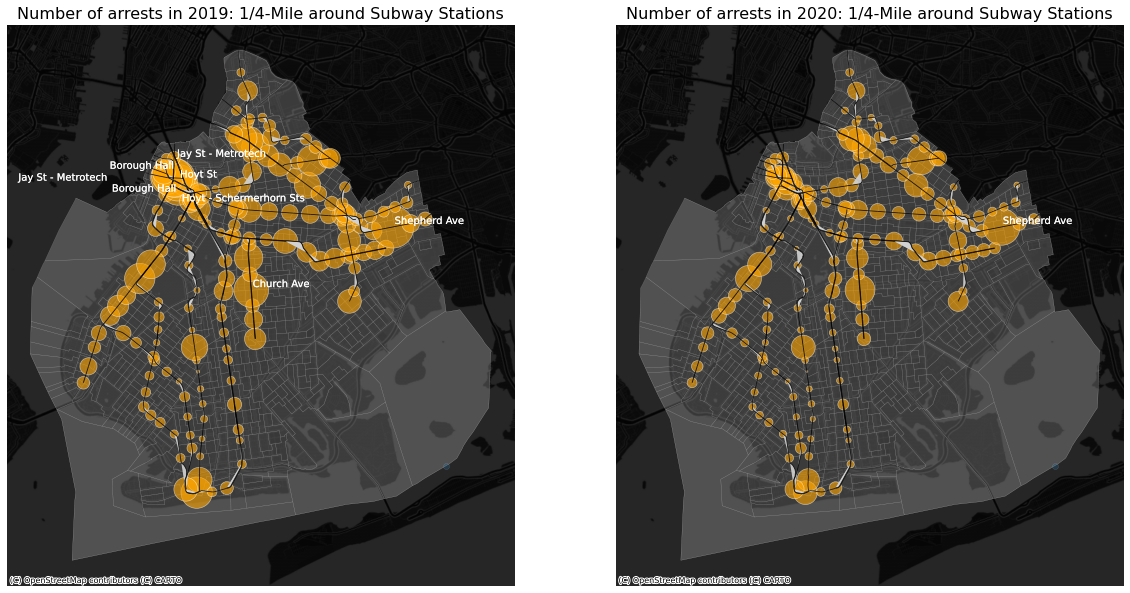

In [21]:
#plotting small multiples of subway stations which had the most arrests in 2019 and 2020 
plt.figure(figsize = (20,16))

#first plot
ax1 = plt.subplot(121)

brooklyn_tracts.plot(alpha = 0.25, legend = True, ax=ax1, edgecolor = 'white', linewidth = .3, facecolor = '#D3D3D3')

brooklyn_lines.plot(alpha = 0.9, legend = True, ax=ax1, edgecolor = 'black', linewidth = .8, facecolor = '#D3D3D3')

brook_sub_arrest_counts_centroids.plot(alpha = 0.6, ax=ax1, legend=True, color = 'orange', edgecolor = 'white', linewidth = .6, markersize = y_2019)

plt.title("Number of arrests in 2019: 1/4-Mile around Subway Stations", size = 16);
ctx.add_basemap(ax1,source=ctx.providers.CartoDB.DarkMatterNoLabels, crs = brooklyn_tracts.crs);
ax1.axis('off')

brook_sub_arrest_counts_high_19['coords'] = brook_sub_arrest_counts_high_19['geometry'].apply(lambda x: x.centroid.coords[:])
brook_sub_arrest_counts_high_19['coords'] = [coords[0] for coords in brook_sub_arrest_counts_high_19['coords']] # eliminate duplicate points
# labelling
labels = [plt.text(brook_sub_arrest_counts_high_19.iloc[i]['coords'][0], 
                  brook_sub_arrest_counts_high_19.iloc[i]['coords'][1],
                  brook_sub_arrest_counts_high_19.iloc[i]['name'].title(), 
                  horizontalalignment='center', size=10,
                  path_effects=[pe.withStroke(linewidth=0.1, )],
                  color='white') for i in range(len(brook_sub_arrest_counts_high_19))]
adjust_text(labels)

#second plot
ax2 = plt.subplot(122)

brooklyn_tracts.plot(alpha = 0.25, legend = True, ax=ax2, edgecolor = 'white', linewidth = .3, facecolor = '#D3D3D3')

brooklyn_lines.plot(alpha = 0.9, legend = True, ax=ax2, edgecolor = 'black', linewidth = .8, facecolor = '#D3D3D3')

brook_sub_arrest_counts_centroids.plot(alpha = 0.6, ax=ax2, legend=True, color = 'orange', edgecolor = 'white', linewidth = .6, markersize = y_2020)

plt.title("Number of arrests in 2020: 1/4-Mile around Subway Stations", size = 16);
ctx.add_basemap(ax2,source=ctx.providers.CartoDB.DarkMatterNoLabels, crs = brooklyn_tracts.crs);
ax2.axis('off')

brook_sub_arrest_counts_high_20['coords'] = brook_sub_arrest_counts_high_20['geometry'].apply(lambda x: x.centroid.coords[:])
brook_sub_arrest_counts_high_20['coords'] = [coords[0] for coords in brook_sub_arrest_counts_high_20['coords']] # eliminate duplicate points
# labelling
labels = [plt.text(brook_sub_arrest_counts_high_20.iloc[i]['coords'][0], 
                  brook_sub_arrest_counts_high_20.iloc[i]['coords'][1],
                  brook_sub_arrest_counts_high_20.iloc[i]['name'].title(), 
                  horizontalalignment='center', size=10,
                  path_effects=[pe.withStroke(linewidth=0.1, )],
                  color='white') for i in range(len(brook_sub_arrest_counts_high_20))]
adjust_text(labels)



Next, we can create an interactive map with folium that helps us publish one or both of these maps. As an example, I've gone ahead with the one showing the arrests in 2019

In [23]:
# Create a new Folium map
eval_js('google.colab.output.setIframeHeight("1000")') # limits the height of output so it doesn't take up the whole notebook screen
map = folium.Map(location=[40.635284252514246, -73.96308579690913], tiles=None, zoom_start=11, height = 850, width = '100%') # percentage width makes it responsive for mobile
folium.TileLayer('CartoDB dark_matter', name='Carto DarkMatter').add_to(map)

#plotting brooklyn tracts
brooklyn_tracts_webm = brooklyn_tracts.to_crs('epsg:4326')
brooklyn_tracts_webm_f = folium.FeatureGroup(name='Brooklyn Tracts',control=True)

for _, r in brooklyn_tracts_webm.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'alpha':0.25, 'fillColor': '#D3D3D3', # fill color
                                                     'color': 'white', # line color
                                                     'weight': 0.3}) # line width
    geo_j.add_to(brooklyn_tracts_webm_f)
brooklyn_tracts_webm_f.add_to(map)

#plotting arrests near subway stations
brook_sub_arrest_counts_centroids_webm = brook_sub_arrest_counts_centroids.to_crs('epsg:4326')
brook_sub_arrest_counts_webm = brook_sub_arrest_counts.to_crs('epsg:4326')
# Create a geometry list from the GeoDataFrame
brook_sub_arrest_list = [[point.xy[1][0], point.xy[0][0]] for point in brook_sub_arrest_counts_centroids_webm.geometry]

i = 0 # initialize counter at zero
for coordinates in brook_sub_arrest_list:   # Iterate through list and add a marker for each dispensary, color-coded by type
    map.add_child( # Place the markers with the popup labels and data
        folium.Circle(location = coordinates,
                      popup = folium.Popup("<b>Name:</b> " + str(brook_sub_arrest_counts_webm.name[i]), 
                                           max_width=len(f"name= {brook_sub_arrest_counts_webm.name[i]}")*20),
                      radius=float(brook_sub_arrest_counts_webm.iloc[i]['2019']), 
                      tooltip = str(brook_sub_arrest_counts_webm.name[i]),
                      color="white", 
                      weight = 0.5,
                      fill=True, 
                      fillOpacity = 0.5,
                      fill_color="orange"))
    i = i + 1

#plotting subway lines

brooklyn_lines_webm = brooklyn_lines.to_crs('epsg:4326')
brooklyn_lines_webm_f = folium.FeatureGroup(name='Subway Lines',control=True)

for _, r in brooklyn_lines_webm.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_l = gpd.GeoSeries(r['geometry'])
    geo_j_l = sim_geo_l.to_json()
    geo_j_l = folium.GeoJson(data=geo_j_l,
                          style_function=lambda x: {'alpha':0.9, 'fillColor': '#D3D3D3', # fill color
                                                    'color': 'white', # line color
                                                    'weight': 0.8}) # line width
    geo_j_l.add_to(brooklyn_lines_webm_f)
brooklyn_lines_webm_f.add_to(map)

#initiating layer control
folium.LayerControl().add_to(map)
map


Lastly, Saving the map in html 

In [25]:
#Exporting the map
map.save('/drive/My Drive/651 - Command-Line GIS/brooklyn_sub_arrests_2019.html')

THE END! Special thanks to Prof. Will B Payne for teaching me this. Check out his awesome work here https://willbpayne.com